<a href="https://colab.research.google.com/github/JamesKevinStar/ClasificarRostrosPersonas/blob/main/Implementaci%C3%B3n%20CNN/Clasificar_Rostros_Personas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio: Clasificación de Rostros de Personas

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importar Librerías

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import Augmentor
import itertools
import pprint
import pickle
import cv2
import os
import re

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

## Cargar Datos

#### <a name="Escritura">Conectar con Drive</a>

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Visión Computacional'
print(os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Visión Computacional
['Datos', 'Redes Neuronales Entrenadas', 'Datos Normalizados', 'Proyecto VC.ipynb']


#### <a name="Escritura">Aumentar Datos</a>

In [ ]:
p = Augmentor.Pipeline(source_directory="Datos/Positivos",output_directory='/content/drive/My Drive/Visión Computacional/Datos/Positivos')
p.rotate(probability=0.5, max_left_rotation=20, max_right_rotation=20)
p.random_brightness(probability=0.3, min_factor=0.3, max_factor=0.3)
p.random_distortion(probability=1, grid_width=2, grid_height=2, magnitude=4)
p.zoom(probability=0.4, min_factor=1.1, max_factor=1.5)
p.sample(100)

Initialised with 3690 image(s) found.
Output directory set to /content/drive/My Drive/Visión Computacional/Datos/Positivos.

Processing <PIL.Image.Image image mode=L size=64x64 at 0x7F4DD47AB610>: 100%|██████████| 7310/7310 [01:13<00:00, 100.01 Samples/s]


In [ ]:
p = Augmentor.Pipeline(source_directory="Datos/Negativos",output_directory='/content/drive/My Drive/Visión Computacional/Datos/Negativos')
p.rotate(probability=0.5, max_left_rotation=20, max_right_rotation=20)
p.random_brightness(probability=0.3, min_factor=0.3, max_factor=0.3)
p.random_distortion(probability=1, grid_width=2, grid_height=2, magnitude=4)
p.zoom(probability=0.4, min_factor=1.1, max_factor=1.5)
p.sample(1525)

Initialised with 9475 image(s) found.
Output directory set to /content/drive/My Drive/Visión Computacional/Datos/Negativos.

Processing <PIL.Image.Image image mode=L size=64x64 at 0x7F4DD5EF70D0>: 100%|██████████| 1525/1525 [00:14<00:00, 105.66 Samples/s]


#### <a name="Escritura">Guardar las imágenes</a>

In [ ]:
def Cargar_Imagenes(Lista, Label):
  for image in os.listdir('Datos/' + Label):
    image = cv2.imread(os.path.join('Datos/' + Label, image))
    image = cv2.resize(image, [64,64])
    Lista.append(image)
  return Lista

Positivos = []
Negativos = []

Positivos = Cargar_Imagenes(Positivos,'Positivos')
Negativos = Cargar_Imagenes(Negativos,'Negativos')

#### <a name="Escritura">Mostrar las imágenes</a>

Positive:  (11000, 64, 64, 3)
Negative:  (11000, 64, 64, 3)


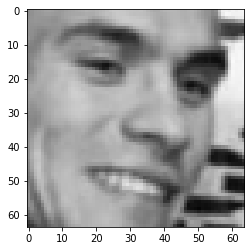

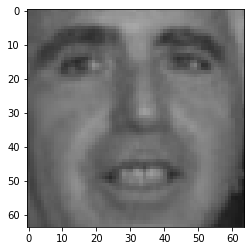

In [ ]:
Images_Positives = np.array(Positivos)
Images_Negatives = np.array(Negativos)
print('Positive: ', str(Images_Positives.shape))
print('Negative: ', str(Images_Negatives.shape))
plt.figure()
plt.imshow(np.squeeze(Images_Positives[0]))
plt.show()
plt.imshow(np.squeeze(Images_Negatives[0]))
plt.show()

## Normalización

#### <a name="Escritura">Crear las etiquetas para las imágenes</a>

In [ ]:
Label_Positives = np.repeat('Positive',Images_Positives.shape[0])
Label_Negatives = np.repeat('Negative',Images_Negatives.shape[0])

print('Positive: ', str(len(Label_Positives)))
print(Label_Positives[0:10])
print('Negative: ', str(len(Label_Negatives)))
print(Label_Negatives[0:10])

Positive:  11000
['Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive']
Negative:  11000
['Negative' 'Negative' 'Negative' 'Negative' 'Negative' 'Negative'
 'Negative' 'Negative' 'Negative' 'Negative']


#### <a name="Escritura">Crear las clases de las etiquetas</a>

In [ ]:
Label_Class = ['Positive','Negative']

#### <a name="Escritura">Dividir las imágenes de test y train</a>

In [ ]:
Images_Train_Positives, Images_Test_Positives, Labels_Train_Positives, Labels_Test_Positives = train_test_split(Images_Positives, Label_Positives, test_size=0.1, random_state=20000901)
Images_Train_Negatives, Images_Test_Negatives, Labels_Train_Negatives, Labels_Test_Negatives = train_test_split(Images_Negatives, Label_Negatives, test_size=0.1, random_state=20000901)

#### <a name="Escritura">Juntar las imágenes de train y test respectivamente</a>

In [ ]:
Images_Train = np.concatenate([Images_Train_Positives,Images_Train_Negatives])
print('Total: ', str(len(Images_Train)))
Images_Train = np.array(Images_Train)
print(Images_Train.shape)

Images_Test = np.concatenate([Images_Test_Positives,Images_Test_Negatives])
print('Total: ', str(len(Images_Test)))
Images_Test = np.array(Images_Test)
print(Images_Test.shape)

Total:  19800
(19800, 64, 64, 3)
Total:  2200
(2200, 64, 64, 3)


#### <a name="Escritura">Juntar las etiquetas de train y test respectivamente</a>

In [ ]:
Labels_Train = np.concatenate([Labels_Train_Positives,Labels_Train_Negatives])
print('Total: ', str(len(Labels_Train)))
print(Labels_Train[0:10])
Labels_Train = np.array(Labels_Train)
print(Labels_Train.shape)

Labels_Test = np.concatenate([Labels_Test_Positives,Labels_Test_Negatives])
print('Total: ', str(len(Labels_Test)))
print(Labels_Test[0:10])
Labels_Test = np.array(Labels_Test)
print(Labels_Test.shape)

Total:  19800
['Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive']
(19800,)
Total:  2200
['Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive']
(2200,)


#### <a name="Escritura">Normalizar las imágenes de test y train</a>

In [ ]:
Images_Train = Images_Train / 255.0
Images_Test = Images_Test / 255.0

#### <a name="Escritura">Normalizar las etiquetas de test y train</a>

In [ ]:
encoder = LabelEncoder()
encoder.fit(Labels_Train)
Labels_Train = encoder.transform(Labels_Train)
Labels_Test = encoder.transform(Labels_Test)
print('Train: ', str(Labels_Train))
print('Test: ', str(Labels_Test))

Train:  [1 1 1 ... 0 0 0]
Test:  [1 1 1 ... 0 0 0]


#### <a name="Escritura">Verificar las imágenes normalizadas</a>

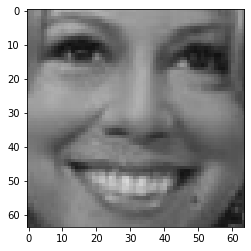

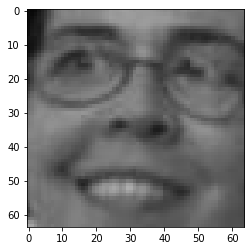

In [ ]:
plt.figure()
plt.imshow(np.squeeze(Images_Train[0]))
plt.show()
plt.imshow(np.squeeze(Images_Test[0]))
plt.show()

#### <a name="Escritura">Guardar los datos normalizados</a>

In [ ]:
Ruta = '/content/drive/My Drive/Visión Computacional/Datos Normalizados/'
Filename = [Ruta + 'Images_Train.pickle',Ruta + 'Labels_Train.pickle',Ruta + 'Images_Test.pickle',Ruta + 'Labels_Test.pickle']
Data = [Images_Train,Labels_Train,Images_Test,Labels_Test]
for i in range(len(Filename)):
  Save_List = open(Filename[i],'wb')
  pickle.dump(Data[i],Save_List)
  Save_List.close()

#### <a name="Escritura">Cargar los datos normalizados</a>

In [ ]:
Ruta = '/content/drive/My Drive/Visión Computacional/Datos Normalizados/'
Filename = [Ruta + 'Images_Train.pickle',Ruta + 'Labels_Train.pickle',Ruta + 'Images_Test.pickle',Ruta + 'Labels_Test.pickle']

Images_Train = pickle.load(open(Filename[0], 'rb'))
Labels_Train = pickle.load(open(Filename[1], 'rb'))
Images_Test = pickle.load(open(Filename[2], 'rb'))
Labels_Test = pickle.load(open(Filename[3], 'rb'))

## Definición de Red Neuronal

#### <a name="Escritura">Definir la arquitectura de la red neuronal</a>

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(64,64,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(units=150, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 128)      

## Entrenamiento de la Red Neuronal

#### <a name="Escritura">Entrenar la red neuronal</a>

In [ ]:
history = model.fit(Images_Train, Labels_Train, batch_size=20, epochs=30, verbose=2, validation_data=(Images_Test, Labels_Test))

Epoch 1/30
990/990 - 5s - loss: 0.4743 - accuracy: 0.7620 - val_loss: 0.3183 - val_accuracy: 0.8823 - 5s/epoch - 5ms/step
Epoch 2/30
990/990 - 4s - loss: 0.3158 - accuracy: 0.8707 - val_loss: 0.2636 - val_accuracy: 0.8932 - 4s/epoch - 4ms/step
Epoch 3/30
990/990 - 4s - loss: 0.2868 - accuracy: 0.8824 - val_loss: 0.2458 - val_accuracy: 0.9014 - 4s/epoch - 4ms/step
Epoch 4/30
990/990 - 4s - loss: 0.2721 - accuracy: 0.8909 - val_loss: 0.2465 - val_accuracy: 0.9027 - 4s/epoch - 4ms/step
Epoch 5/30
990/990 - 4s - loss: 0.2588 - accuracy: 0.8974 - val_loss: 0.2219 - val_accuracy: 0.9100 - 4s/epoch - 4ms/step
Epoch 6/30
990/990 - 4s - loss: 0.2449 - accuracy: 0.9026 - val_loss: 0.2336 - val_accuracy: 0.9014 - 4s/epoch - 4ms/step
Epoch 7/30
990/990 - 4s - loss: 0.2403 - accuracy: 0.9033 - val_loss: 0.2180 - val_accuracy: 0.9123 - 4s/epoch - 4ms/step
Epoch 8/30
990/990 - 4s - loss: 0.2359 - accuracy: 0.9069 - val_loss: 0.2096 - val_accuracy: 0.9168 - 4s/epoch - 4ms/step
Epoch 9/30
990/990 - 4s 

#### <a name="Escritura">Graficar la función de perdida</a>

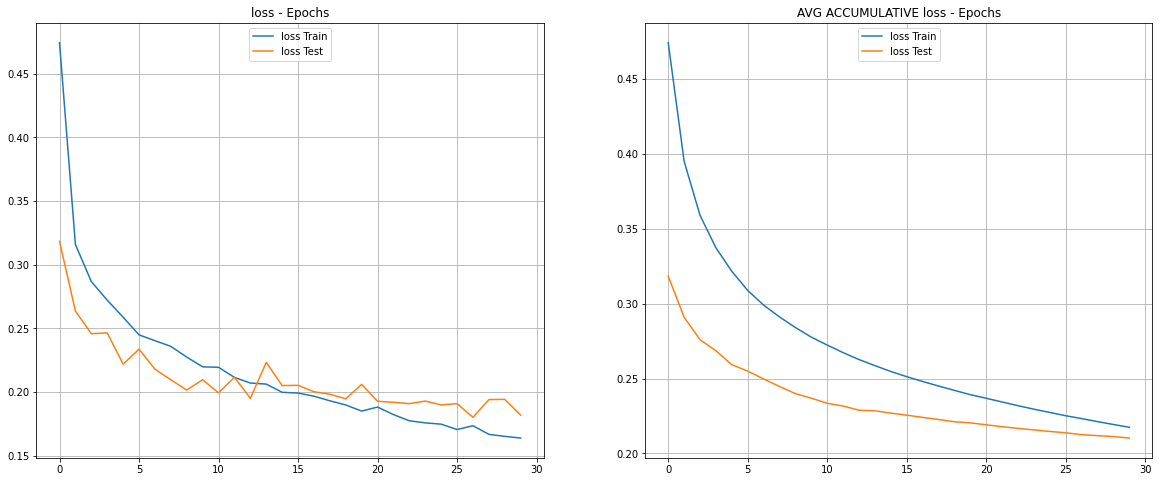

In [ ]:
%matplotlib inline
# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()
    
plot_metric(history=history, name='loss')

#### <a name="Escritura">Graficar la función de accuracy</a>

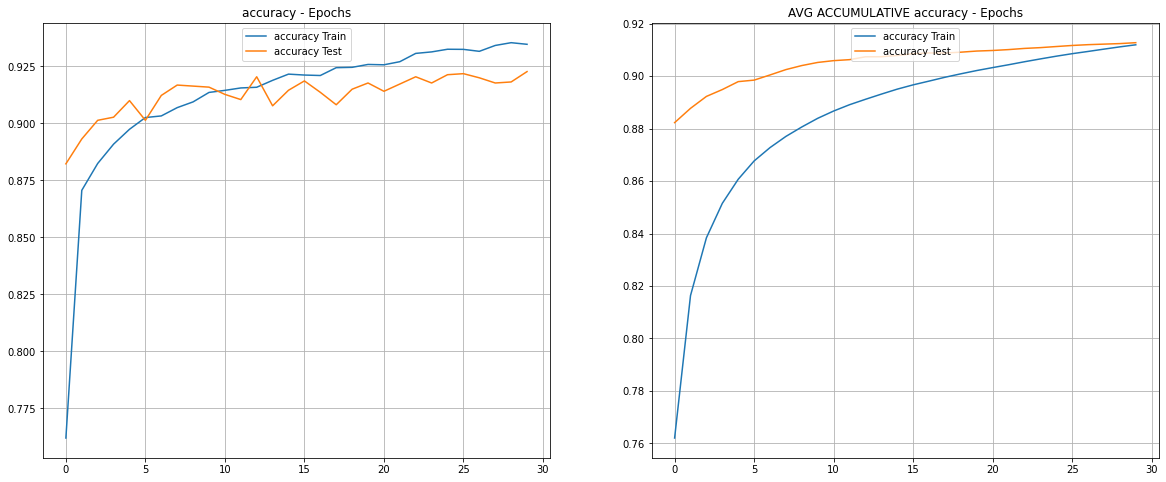

In [ ]:
plot_metric(history=history, name='accuracy')

## Guardar Modelo Entrenado

In [ ]:
model.save('/content/drive/My Drive/Visión Computacional/Redes Neuronales Entrenadas/CNN_Entrenada.h5')

## Evaluación del Modelo

#### <a name="Escritura">Calcular las diferentes métricas</a>

In [ ]:
Y_true = encoder.inverse_transform(Labels_Test.reshape(-1))
X_pred = model.predict(Images_Test)
X_pred_train = model.predict(Images_Train)
Y_pred = np.argmax(X_pred,axis=1)
Y_pred_train = np.argmax(X_pred_train,axis=1)
Y_pred = encoder.inverse_transform(Y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=Y_true, y_pred=Y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=Y_true, y_pred=Y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=Y_true, y_pred=Y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=Y_true, y_pred=Y_pred, average='weighted')))
print(classification_report(y_true=Y_true, y_pred=Y_pred))

confusion_matrix_test = confusion_matrix(y_true=Y_true,
                                         y_pred=Y_pred,
                                         labels=Label_Class)
confusion_matrix_train = confusion_matrix(y_true=encoder.inverse_transform(Labels_Train.reshape(-1)), 
                                          y_pred=encoder.inverse_transform(Y_pred_train), 
                                          labels=Label_Class)

Accuracy: 0.9227
F1: 0.9227
Precision: 0.9232
Recall: 0.9227
              precision    recall  f1-score   support

    Negative       0.94      0.91      0.92      1100
    Positive       0.91      0.94      0.92      1100

    accuracy                           0.92      2200
   macro avg       0.92      0.92      0.92      2200
weighted avg       0.92      0.92      0.92      2200



#### <a name="Escritura">Mostrar las matrices de confusión</a>

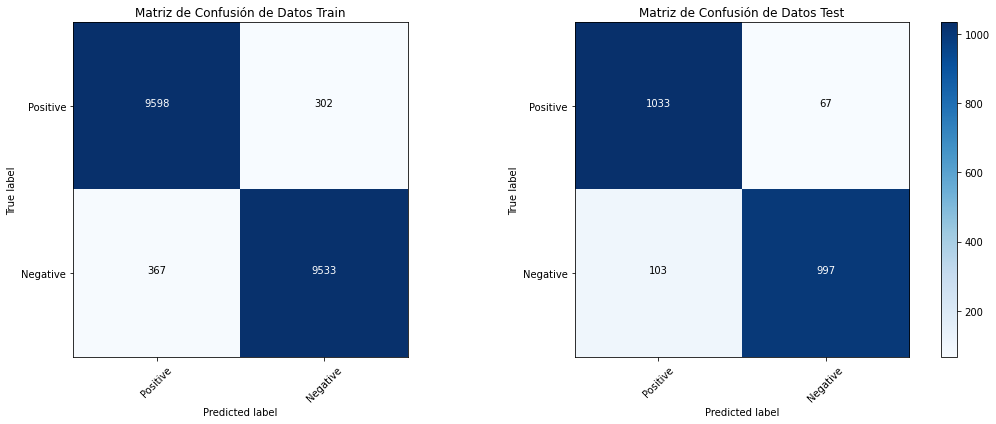

In [ ]:
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix_train, classes=Label_Class, title='Matriz de Confusión de Datos Train')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix_test, classes=Label_Class, title='Matriz de Confusión de Datos Test')
plt.show()

#### <a name="Escritura">Probar con imágenes nuevas</a>

======================== PREDICCIONES ========================
array([[1.0326452e-01, 8.9673549e-01],
       [1.5202357e-01, 8.4797645e-01],
       [9.9999499e-01, 5.0151989e-06]], dtype=float32)


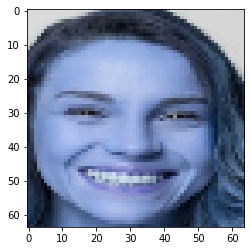

La imagen pertenece a: Positive


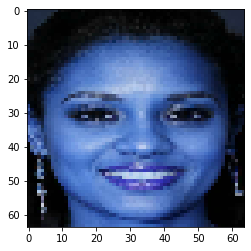

La imagen pertenece a: Positive


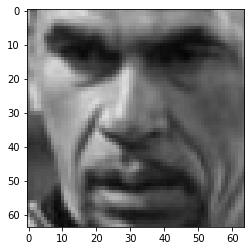

La imagen pertenece a: Negative


In [ ]:
def Img_Prueba(Lista):
  for image in os.listdir('/content/drive/My Drive/Visión Computacional/Prueba'):
    image = cv2.imread(os.path.join('/content/drive/My Drive/Visión Computacional/Prueba', image))
    image = cv2.resize(image, [64,64])
    Lista.append(image)
  return Lista

img = []
img = Img_Prueba(img)
img = np.array(img)
img = img/255.0

pred = model.predict(img)
print('======================== PREDICCIONES ========================')
pprint.pprint(pred)
labels = ['Negative', 'Positive']
for i in range(0,len(img)):
  plt.figure()
  plt.imshow(np.squeeze(img[i]))
  plt.show()
  print('La imagen pertenece a: ' + labels[np.argmax(pred[i])])
